Coefficients c =
Matrix([[15*a**2*b**2*q0*(1 - nu**2)/(2*E*h**3*(3*a**4 + 5*a**2*b**2 + 3*b**4))], [0], [0], [0]])
Displacement w =
-15*a**2*b**2*q0*x*y*(a - x)*(b - y)*(nu**2 - 1)/(2*E*h**3*(3*a**4 + 5*a**2*b**2 + 3*b**4))
Total Potential Energy Pi =
-0.0225900606060606


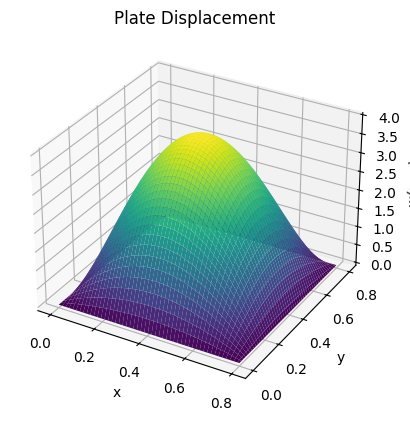

In [1]:
from sympy import symbols, integrate, Matrix, simplify, diff, zeros, lambdify, solve, pi
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Define symbolic variables
x, y, h, q0, E, nu, a, b = symbols('x y h q0 E nu a b')

# Define constants
params = {E: 200e9, nu: 0.3, h: 0.02, q0: 4e3, a: 0.8, b: 0.8}

# Define the flexural rigidity D
D = E * h**3 / (12 * (1 - nu**2))

# Define approximation functions (basis functions for Ritz method)
phi = Matrix([[x * (x - a) * y * (y - b),
               x * (x - a) * y * (y - b)**2,
               x * (x - a)**2 * y * (y - b),
               x * (x - a)**2 * y * (y - b)**2]])

# Compute second derivatives
dphixx = diff(phi, x, x)
dphiyy = diff(phi, y, y)
dphixy = diff(phi, x, y)

# Number of approximation functions
n = 4

# Initialize stiffness matrix K and force vector F
K = zeros(n, n)
F = zeros(n, 1)

# Compute K and F
for i in range(n):
    for j in range(n):
        # Integrand for stiffness matrix
        integrand = (dphixx[i] * (dphixx[j] + nu * dphiyy[j]) +
                     dphiyy[i] * (dphiyy[j] + nu * dphixx[j]) +
                     2 * (1 - nu) * dphixy[i] * dphixy[j])
        aux = integrate(integrate(integrand, (x, 0, a)), (y, 0, b))
        if i <= j:
            K[i, j] = D * aux
        else:
            K[i, j] = K[j, i]  # Symmetry of stiffness matrix
    # Integrand for force vector
    aux2 = integrate(integrate(phi[i] * q0, (x, 0, a)), (y, 0, b))
    F[i] = aux2

# Solve for coefficients c
c = simplify(K.inv() * F)
print('Coefficients c =')
print(c)

# Compute displacement w
w = phi * c
w = simplify(w[0])  # Extract scalar from matrix
print('Displacement w =')
print(w)

# Compute total potential energy Pi
Pi = D * 0.5 * integrate(integrate(
    (w.diff(x, x) + w.diff(y, y))**2 +
    2 * (1 - nu) * (w.diff(x, y)**2 - w.diff(x, x) * w.diff(y, y)) -
    q0 * w * 2 / D, (x, 0, a)), (y, 0, b))

# Substitute numerical parameters
Pi_num = Pi.subs(params)
print('Total Potential Energy Pi =')
print(Pi_num.evalf())

w_func = lambdify((x, y, a, b), w.subs(params), 'numpy')

# Create mesh for plotting
x_vals = np.linspace(0, params[a], 100)
y_vals = np.linspace(0, params[b], 100)
X, Y = np.meshgrid(x_vals, y_vals)
Z = w_func(X, Y, params[a], params[b])

# 3D Plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap='viridis')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('w(x, y)')
ax.set_title('Plate Displacement')
plt.show()

Convergence Analysis:


 67%|██████▋   | 2/3 [00:00<00:00, 14.23it/s]

n = 1, Total Potential Energy Pi = -2.259006e-02 J
n = 2, Total Potential Energy Pi = -2.340398e-02 J


100%|██████████| 3/3 [00:00<00:00,  7.00it/s]

n = 4, Total Potential Energy Pi = -2.432906e-02 J


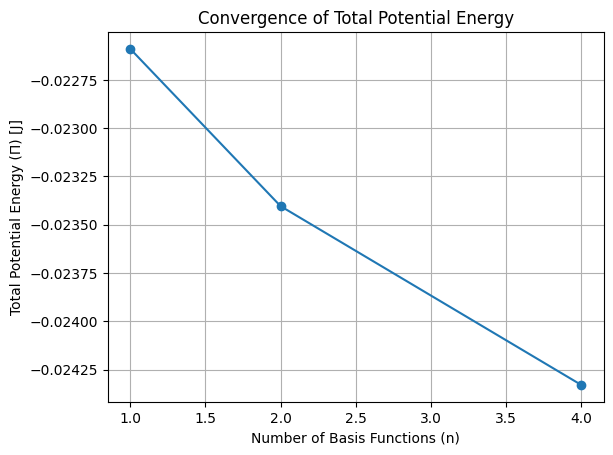

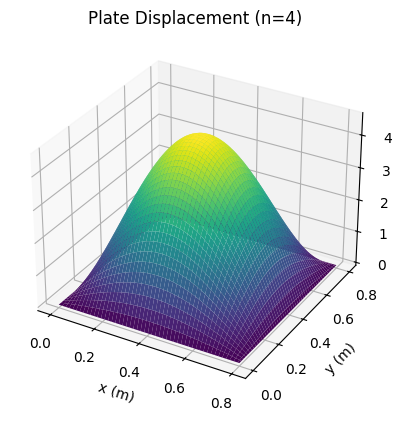

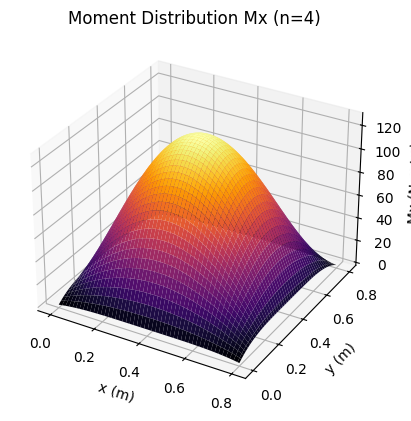

In [7]:
from sympy import symbols, Matrix, diff, zeros, lambdify
from scipy.integrate import dblquad
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm

D_num = D.subs(params).evalf()  # Pre-compute numerical value of D
q0_num = params[q0]

def get_basis_functions(n_terms):
    if n_terms < 1:
        raise ValueError("n_terms must be at least 1")
    
    # Define (m, n) pairs for basis functions [x (x - a)]^m [y (y - b)]^n
    if n_terms == 1:
        degrees = [(1, 1)]
    elif n_terms == 2:
        degrees = [(1, 1), (1, 2)]
    elif n_terms == 3:
        degrees = [(1, 1), (1, 2), (2, 1)]
    elif n_terms == 4:
        degrees = [(1, 1), (1, 2), (2, 1), (2, 2)]
    else:
        raise ValueError("Unsupported number of terms")
    
    phi = Matrix([(x * (x - a))**m * (y * (y - b))**n for m, n in degrees])
    return phi

# Function to compute K, F, c, w, and Pi using numerical integration
def compute_solution(phi, n):
    # Lambdify derivatives for numerical integration
    dphixx = diff(phi, x, x)
    dphiyy = diff(phi, y, y)
    dphixy = diff(phi, x, y)
    
    K = zeros(n, n)
    F = zeros(n, 1)
    
    # Numerical integration for K and F
    for i in range(n):
        for j in range(n):
            integrand_expr = D * (
                (dphixx[i] + dphiyy[i]) * (dphixx[j] + dphiyy[j]) +
                2 * (1 - nu) * (dphixy[i] * dphixy[j] - dphixx[i] * dphiyy[j])
            )
            integrand = lambdify((x, y), integrand_expr.subs(params).evalf(), 'numpy')
            K[i, j], _ = dblquad(integrand, 0, params[b], lambda _: 0, lambda _: params[a])
            if i > j:
                K[i, j] = K[j, i]
        aux2_expr = q0 * phi[i]
        aux2 = lambdify((x, y), aux2_expr.subs(params).evalf(), 'numpy')
        F[i], _ = dblquad(aux2, 0, params[b], lambda _: 0, lambda _: params[a])
    
    c = K.inv() * F
    w = sum(c[i, 0] * phi[i, 0] for i in range(n))
    
    # Numerical integration for Pi
    w_xx = w.diff(x, x)
    w_yy = w.diff(y, y)
    w_xy = w.diff(x, y)
    Pi_integrand_expr = 0.5 * D * (
        (w_xx + w_yy)**2 +
        2 * (1 - nu) * (w_xy**2 - w_xx * w_yy)
    ) - q0 * w
    Pi_integrand = lambdify((x, y), Pi_integrand_expr.subs(params).evalf(), 'numpy')
    Pi_num, _ = dblquad(Pi_integrand, 0, params[b], lambda _: 0, lambda _: params[a])
    
    return c, w, Pi_num

# Convergence analysis
n_values = [1, 2, 4]
Pi_values = []
w_functions = []

print("Convergence Analysis:")
for n in tqdm(n_values):
    phi = get_basis_functions(n)
    c, w, Pi_num = compute_solution(phi, n)
    Pi_values.append(float(Pi_num))
    w_functions.append(w)
    print(f"n = {n}, Total Potential Energy Pi = {Pi_num:.6e} J")

# Plot convergence
plt.figure()
plt.plot(n_values, Pi_values, marker='o')
plt.xlabel('Number of Basis Functions (n)')
plt.ylabel('Total Potential Energy (Π) [J]')
plt.title('Convergence of Total Potential Energy')
plt.grid(True)
plt.show()

# Best approximation (n=4)
phi_best = get_basis_functions(4)
c_best, w_best, Pi_best = compute_solution(phi_best, 4)

# Plot deformed plate (w(x, y))
w_func = lambdify((x, y), w_best.subs(params), 'numpy')
x_vals = np.linspace(0, params[a], 100)
y_vals = np.linspace(0, params[b], 100)
X, Y = np.meshgrid(x_vals, y_vals)
Z = w_func(X, Y)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap='viridis')
ax.set_xlabel('x (m)')
ax.set_ylabel('y (m)')
ax.set_zlabel('w(x, y) (m)')
ax.set_title('Plate Displacement (n=4)')
plt.show()

# Compute and plot moment Mx = -D (w_xx + ν w_yy)
Mx = -D * (w_best.diff(x, x) + nu * w_best.diff(y, y))
Mx_func = lambdify((x, y), Mx.subs(params).evalf(), 'numpy')
Mx_vals = Mx_func(X, Y)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Mx_vals, cmap='inferno')
ax.set_xlabel('x (m)')
ax.set_ylabel('y (m)')
ax.set_zlabel('Mx (N·m/m)')
ax.set_title('Moment Distribution Mx (n=4)')
plt.show()